In [32]:
import torch
print("Pytorch " + torch.__version__)
import pandas as pd
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import Trainer, TrainingArguments, EvalPrediction
from datasets import load_dataset

from sklearn import metrics
from scipy import stats
from functools import partial
from tqdm.auto import tqdm

from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# Create device agnostic code

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

Pytorch 1.13.1


'cuda'

In [38]:
cas_voc = pd.read_csv("./cas_voc.tsv", sep="\t")
cas_tree = cas_voc
print(cas_tree)


             Loci_id Strand  Genome_assembly     Chromosome      N1  \
0         RN99_05230      -  GCA_001296125.1     CP012714.1   991.0   
1         RN99_05235      -  GCA_001296125.1     CP012714.1   992.0   
2         RN99_05240      -  GCA_001296125.1     CP012714.1   993.0   
3         RN99_05245      -  GCA_001296125.1     CP012714.1   994.0   
4          Tel_12180      -  GCA_001447805.1     CP013099.1  2369.0   
...              ...    ...              ...            ...     ...   
36965  DQN35_RS05450      -  GCF_900476015.1  NZ_LS483442.1   987.0   
36966  EL095_RS09000      -  GCF_900636345.1  NZ_LR134264.1  1709.0   
36967  EL095_RS09005      -  GCF_900636345.1  NZ_LR134264.1  1710.0   
36968  EL095_RS09010      -  GCF_900636345.1  NZ_LR134264.1  1711.0   
36969  EL095_RS09015      -  GCF_900636345.1  NZ_LR134264.1  1712.0   

           Protein_id B2    Gene_id Gene_family      Type  \
0          ALF19893_1  +    cd09644        csn2  CAS-II-A   
1          ALF20727_1  + 

In [41]:
#Preparing fasta file for MUSCLE multi alignment that is used through cmd (because of PATH problems)

import Bio
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
cas_tree = cas_tree[["Gene_family", "Loci_id", "Gene_id", "Prot"]]
fasta_list = []
for i, row in cas_tree.iterrows():
    
    seq = Bio.Seq.Seq(row["Prot"])
    seq_rec = SeqRecord(seq, id=f"{row.Gene_family}|{row.Loci_id}|{row.Gene_id}", description="")
    fasta_list.append(seq_rec)
with open('cas_tree.fasta', 'w') as output_handle:
    SeqIO.write(fasta_list, output_handle, 'fasta')


In [73]:
# Generating distance matrix for embedings
cas_voc = pd.read_csv("./cas_voc.tsv", sep="\t")
cas_tree = cas_voc


In [74]:
cas_tree["Id"] = cas_tree["Gene_family"]+'|'+cas_tree["Loci_id"]+"|"+cas_tree["Gene_id"]

# This saving embeddings as np.array should have been done in the first place
emb_list = []
for i, row in cas_tree.iterrows():
    emb = np.fromstring(row["Embs"], sep=',')
    emb_list.append(emb)
cas_tree["Embs"] = emb_list
print(cas_tree["Embs"])

0        [0.051016684621572495, 0.04367627203464508, -0...
1        [0.06999336928129196, -0.009389735758304596, -...
2        [0.04088897258043289, -0.006158418953418732, 0...
3        [-0.005716726183891296, -0.0009562690975144506...
4        [0.026958098635077477, 0.01683950051665306, -0...
                               ...                        
36965    [0.016407648101449013, -0.023550499230623245, ...
36966    [0.03171134740114212, 0.014154933393001556, -0...
36967    [0.003894316963851452, -0.017147328704595566, ...
36968    [0.020528120920062065, -0.02067919448018074, -...
36969    [0.012388630770146847, -0.002105067018419504, ...
Name: Embs, Length: 36970, dtype: object


In [98]:
from scipy.spatial import distance_matrix
ids = cas_tree["Id"].tolist()
embs = cas_tree["Embs"].tolist()

distances = distance_matrix(embs, embs)
double_dist_matrix_np = np.tril(distances)
del distances
double_dist_matrix = double_dist_matrix_np.tolist()
del double_dist_matrix_np
dist_matrix = []
for i, row in enumerate(double_dist_matrix):
    dist_matrix.append(row[0:i+1])
print(dist_matrix)

MemoryError: Unable to allocate 10.2 GiB for an array with shape (36970, 36970) and data type float64

In [97]:
import Bio
dm = Bio.Phylo.TreeConstruction.DistanceMatrix(names=ids, matrix=dist_matrix)

from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)
for inner in tree.get_nonterminals():
    inner.name = ''
for outer in tree.get_terminals():
    outer.name = outer.name

Bio.Phylo.draw(tree)
print(type(tree))

Tree(rooted=False)
    Clade(branch_length=0, name='')
        Clade(branch_length=0.0016863845890923296, name='')
            Clade(branch_length=0.03749131258871227, name='')
                Clade(branch_length=0.04583274901000589, name='')
                    Clade(branch_length=0.26339616441765623, name='cas7b|CKL_RS13495|pfam05107')
                    Clade(branch_length=0.020524686789149593, name='')
                        Clade(branch_length=0.22070239644562673, name='cas7|CTHE_RS11965|cd09687')
                        Clade(branch_length=0.19449330533169917, name='')
                            Clade(branch_length=0.20738506280815622, name='cas7|ECO111_RS18220|cd09646')
                            Clade(branch_length=0.10697633161157366, name='cas7|Y75_RS14385|cd09646')
                Clade(branch_length=0.027894274733493485, name='')
                    Clade(branch_length=0.17210359554381088, name='cas7|CSAC_RS12130|cd09687')
                    Clade(branch_length=0.14273

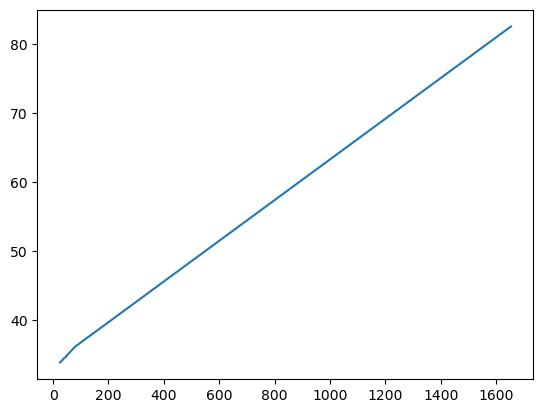

In [3]:
import matplotlib.pyplot as plt
x = [33.9, 34.6, 34.7, 35, 35.3, 35.8, 36.2, 82.5  
]
y = [25, 42, 46, 51, 59, 70, 80, 1653]
plt.plot(y, x)
plt.show()